In [1]:
from sys import executable
!{executable} -m pip install tqdm pandas matplotlib

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm.notebook import tqdm

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Preprocess files with https://github.com/amir-zeldes/rst2dep

In [3]:
# Processing rs3 files with Zeldes's parser
base_dir = "./"
rs3_dir = base_dir + "data/schizo/healthy/rs3/"

rs3_files = [rs3_dir + file for file in listdir(rs3_dir) if file.endswith('.rs3')]

for file_name in tqdm(rs3_files):
    !./rst2dep/rst2dep.py {file_name}

In [4]:
# Counting lost files 
rsd_dir = base_dir + "data/schizo/healthy/rsd/"
rsd_files = [file for file in listdir(rsd_dir) if file.endswith('.rsd')]

f"We have a {100 - len(rsd_files) / len(rs3_files) * 100 :.2f}% data loss with this parser"

'We have a 0.00% data loss with this parser'

### Parse preprocessed files and process them to csv

In [5]:
import re

URL_REGEXP = r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*'

def process_string(string, file_name):
    '''
    Function for deleting EDUs containing IMG,
    changes URLs to "здесь",
    changes "minus" to "longdash"
    '''
    string = string.replace('IMG', '')
    string = re.sub(URL_REGEXP, 'здесь', string)

    if string.startswith("-"):
        string = u"—" + string[1:]

    return string.strip()

In [6]:
import csv
from io import StringIO

processed_dir = base_dir + 'data/schizo/healthy/processed/'

for file_name in tqdm(rsd_files): 
    # headers
    result = ['EDU_1;EDU_2;Relation'] 

    # opens rsd-file
    with open(rsd_dir + file_name) as file: 
        csv_str = file.read() + '\n' 
        # We need to delete the ' and " characters from the csv
        escaped_csv_str = csv_str.replace("\"", '').replace("\'", '').replace(";", '')

    # reading csv to df  
    df = pd.read_csv(StringIO(escaped_csv_str),
                     sep="\t",
                     encoding='utf-8',
                     names=["self_id", "snippet", "q", "w", "e", "feats", "dep_parent", "dep_rel", "r", "t"])
    
    # deleting ROOTs (the highest groups of EDUs in the hierarchy) and EDUs which are IMG files
    for index, row in df.iterrows():
        if row['dep_rel'].strip() == 'ROOT' or row['snippet'].strip() == "IMG":
            continue
            
        # searching parent for EDU1
        parent_snippet_vals = df[df['self_id'] == row['dep_parent']].values

        if len(parent_snippet_vals) != 0:
            snippet_text = process_string(row['snippet'], file_name)
            parent_text = process_string(parent_snippet_vals[0][1], file_name)

            result.append(';'.join([snippet_text,
                                   parent_text,
                                   row['dep_rel']]))
            
        # writing result into csv
        with open(processed_dir + file_name[:-4] + '.csv', 'w', encoding='utf-8') as fout:
            fout.write('\n'.join(result))

### Merging CSV files into DataFrame

In [7]:
import glob

In [8]:
all_files = glob.glob(processed_dir + "/*.csv")
df_list = [pd.read_csv(filename, index_col=None, header=0, sep=';') for filename in all_files]

df = pd.concat(df_list, axis=0, ignore_index=True)
df.dropna()

,EDU_1,EDU_2,Relation
0,ну я б сказала 1,не очень правдоподобная история 2,evaluation_r
1,не очень правдоподобная история 2,человек собирает груши 15,antithesis_r
2,потому что этот человек 3,не очень правдоподобная история 2,cause_r
3,убирающий собирающий груши 4,потому что этот человек 3,elaboration_r
4,наверняка он все-таки звук слышит хорошо 5,потому что этот человек 3,joint_m
...,...,...,...
544,он их за это угостил грушами вот 47,но это самое а шляпа-то у него улетела тоже 43,result_r
545,это то есть мальчик такой ну благодарный 48,вот поехал дальше 42,antithesis_r
546,будем говорить да 49,это то есть мальчик такой ну благодарный 48,antithesis_r
547,вот ну и в общем повёз это всё домой помощник 50,вот поехал дальше 42,sequence_m


### Analytics

In [9]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 12

pd.options.display.float_format = '{:,.3f}'.format

In [10]:
df.describe()

,EDU_1,EDU_2,Relation
count,549,549,549
unique,549,224,20
top,почему мужчина его не заметил 27,мужчина с усами собирает груши 2,sequence_m
freq,1,15,158


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   EDU_1     549 non-null    object
 1   EDU_2     549 non-null    object
 2   Relation  549 non-null    object
dtypes: object(3)
memory usage: 13.0+ KB


In [12]:
list(df['Relation'].unique())

['evaluation_r',
 'antithesis_r',
 'cause_r',
 'elaboration_r',
 'joint_m',
 'restatement_r',
 'preparation_r',
 'sequence_m',
 'contrast_m',
 'evidence_r',
 'concession_r',
 'result_r',
 'circumstance_r',
 'justify_r',
 'purpose_r',
 'background_r',
 'condition_r',
 'motivation_r',
 'solutionhood_r',
 'restatement_m']

In [13]:
len(list(df['Relation'].unique()))

20

In [14]:
df_table = df['Relation'].value_counts().rename_axis('Relation').to_frame('Number of EDUs').astype('int32')

df_table['Percentage'] = (df_table['Number of EDUs'] / sum(df_table['Number of EDUs']) * 100)
df_table['Percentage'] = df_table['Percentage'].round(2).astype(str) + ' %'

df_table

,Number of EDUs,Percentage
Relation,,
sequence_m,158,28.78 %
antithesis_r,71,12.93 %
elaboration_r,42,7.65 %
circumstance_r,41,7.47 %
evaluation_r,41,7.47 %
joint_m,36,6.56 %
cause_r,32,5.83 %
result_r,31,5.65 %
background_r,22,4.01 %


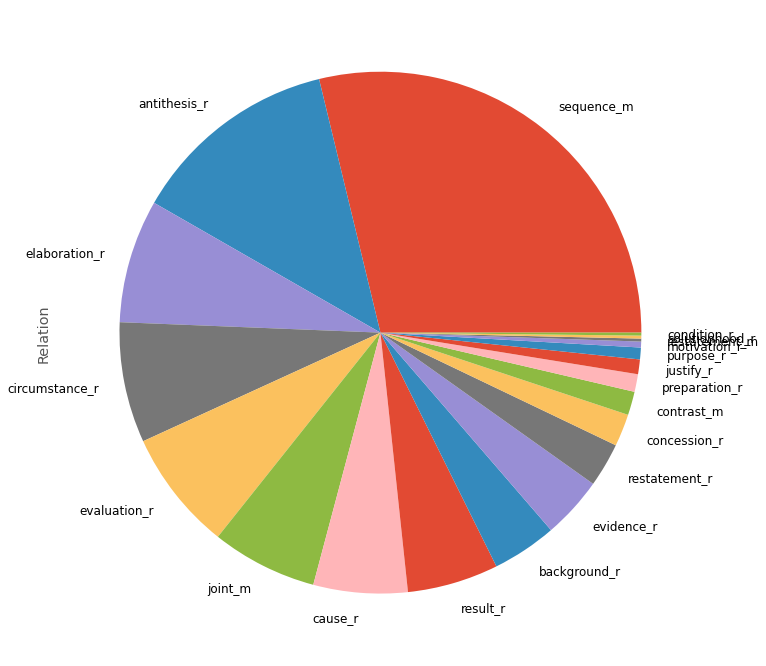

In [15]:
df['Relation'].value_counts().plot(kind='pie')

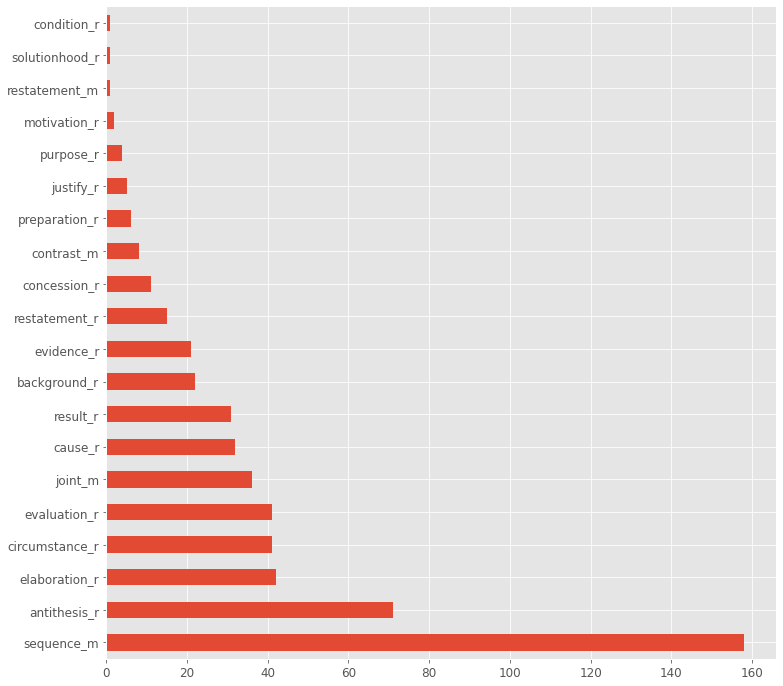

In [16]:
df['Relation'].value_counts().plot(kind='barh')

In [17]:
df['EDU_1_count'] = df['EDU_1'].str.findall(r'(\w+)').str.len()
df['EDU_1_count'] = df['EDU_1_count'].dropna().astype('int32')
df['EDU_1_count']

0       5
1       5
2       5
3       4
4       8
       ..
544     8
545     8
546     4
547    11
548     7
Name: EDU_1_count, Length: 549, dtype: int32

In [18]:
df['EDU_2_count'] = df['EDU_2'].str.findall(r'(\w+)').str.len()
df['EDU_2_count'] = df['EDU_2_count'].dropna().astype('int32')
df['EDU_2_count']

0       5
1       4
2       5
3       5
4       5
       ..
544    11
545     4
546     8
547     4
548     3
Name: EDU_2_count, Length: 549, dtype: int32

In [19]:
EDU_1_count = df['EDU_1_count'].dropna().sum().astype('int32')
EDU_1_count

3083

In [20]:
EDU_1_count_unique = df['EDU_1_count'].dropna().unique().sum().astype('int32')
EDU_1_count_unique

135

In [21]:
EDU_2_count = df['EDU_2_count'].dropna().sum().astype('int32')
EDU_2_count

3306

In [22]:
EDU_2_count_unique= df['EDU_2_count'].dropna().unique().sum().astype('int32')
EDU_2_count_unique

135

In [23]:
word_count = EDU_1_count + EDU_2_count
f"Total words amount: {word_count}"

'Total words amount: 6389'

In [24]:
word_count_unique = EDU_1_count_unique + EDU_2_count_unique
f"Total unique words amount: {word_count_unique}"

'Total unique words amount: 270'

In [25]:
df_edus = df['EDU_1'] + df['EDU_2']
df_edus = df_edus.to_frame()
df_edus

,0
0,ну я б сказала 1не очень правдоподобная история 2
1,не очень правдоподобная история 2человек собир...
2,потому что этот человек 3не очень правдоподобн...
3,убирающий собирающий груши 4потому что этот че...
4,наверняка он все-таки звук слышит хорошо 5пото...
...,...
544,он их за это угостил грушами вот 47но это само...
545,это то есть мальчик такой ну благодарный 48вот...
546,будем говорить да 49это то есть мальчик такой ...
547,вот ну и в общем повёз это всё домой помощник ...
